# Importing the Libraries

In [78]:
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Defining a user for testing

In [79]:
user_id = 582

# Loading and Pre-processing

In [80]:
def load_and_preprocess_data():
    # Load data
    movie_data = pd.read_csv('data/movies_grouplens/movies.dat',
                             delimiter='::', header=None, engine='python', encoding='latin1')
    rating_data = pd.read_csv('data/movies_grouplens/ratings.dat',
                              delimiter='::', header=None, engine='python', encoding='latin1')
    user_data = pd.read_csv('data/movies_grouplens/users.dat',
                            delimiter='::', header=None, engine='python', encoding='latin1')

    # Set column names
    movie_data.columns = ['MovieID', 'Title', 'Genres']
    rating_data.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
    user_data.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

    # Merge datasets
    df = pd.merge(rating_data, movie_data, on='MovieID', how='left')
    df = pd.merge(df, user_data, on='UserID', how='left')

    # Convert categorical variables
    df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

    # Create index mappings
    users = df['UserID'].unique()
    movies = df['MovieID'].unique()

    user_to_idx = {user: idx for idx, user in enumerate(users)}
    movie_to_idx = {movie: idx for idx, movie in enumerate(movies)}

    # Add index columns
    df['User_idx'] = df['UserID'].map(user_to_idx)
    df['Movie_idx'] = df['MovieID'].map(movie_to_idx)

    # Normalize age and occupation values to start from 0
    df['Age'] = df['Age'] - df['Age'].min()
    df['Occupation'] = df['Occupation'] - df['Occupation'].min()

    return df, user_to_idx, movie_to_idx

### Defining the device

In [81]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda') if torch.cuda.is_available() else device

### Loading the Model

In [82]:
ncf_cnn_model = torch.jit.load(
    'models/NCF_CNN_Enchanced_more_epoch.pt', map_location=device)

In [83]:
data, user_to_idx, movie_to_idx = load_and_preprocess_data()
idx_to_movie = {v: k for k, v in movie_to_idx.items()}
idx_to_user = {v: k for k, v in user_to_idx.items()}

# Generating Recommendations

In [84]:
def get_recommendations(user_id, model, data, user_to_idx, idx_to_movie, device, path='data/movies_grouplens/users.dat'):
    user_data = pd.read_csv(path,
                            delimiter='::', header=None, engine='python', encoding='latin1')

    user_data.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
    user_idx = user_to_idx[user_id]

    user_data['Gender'] = user_data['Gender'].map({'M': 0, 'F': 1})
    user_data['Age'] = user_data['Age'] - user_data['Age'].min()
    user_data['Occupation'] = user_data['Occupation'] - \
        user_data['Occupation'].min()

    ud = user_data[(user_data['UserID'] == user_id)].values
    not_watched = []
    list_ratings = []

    movie_idxs = np.arange(data['Movie_idx'].min(),
                           data['Movie_idx'].max()+1, 1)

    for movie in movie_idxs:
        if (not len(data[(data['User_idx'] == user_idx) & (data['Movie_idx'] == movie)]['Movie_idx'].to_list())):
            not_watched.append(movie)
        # else:
        #     print(f'Already Wacthed {movie}')

    for movie in not_watched:
        movie_features = ['Title', 'Genres']
        title, genres = data.iloc[data[data['Movie_idx']
                                       == movie].index[0]][movie_features]
        gender, age, occupation = ud[0][1:4]
        # print(gender, age, occupation)
        rating = model(torch.tensor([user_idx]).to(device), torch.tensor([movie]).to(device), torch.tensor(
            [gender]).to(device), torch.tensor([age]).to(device), torch.tensor([occupation]).to(device))

        list_ratings.append([user_id, idx_to_movie
                             [movie], title,
                            genres, gender, age, occupation, rating.item()])


# Define the column names
    column_names = ['UserID', 'MovieID', 'Title',
                    'Genres', 'Gender', 'Age', 'Occupation', 'Rating']

    # Create a DataFrame
    df_list = pd.DataFrame(list_ratings, columns=column_names)
    return df_list

## CF

In [85]:
cf_recommendations = get_recommendations(user_id, ncf_cnn_model, data,
                                         user_to_idx, idx_to_movie, device)

## CBF


In [86]:
from src.modules.CBF import CBF
cbf = CBF()

In [87]:
cbf_recommendations = cbf.cbf_recommend_movies(user_id)

## Generating Hybrid Recommendations

In [88]:
hybrid_recommendations = cf_recommendations.merge(
    cbf_recommendations, on=['MovieID', 'Title', 'Genres'])

In [89]:
hybrid_recommendations['Ensemble_Rating'] = 0.9 * \
    hybrid_recommendations['Rating'] + 0.1*hybrid_recommendations['Score']

In [90]:
hybrid_recommendations.sort_values(by='Ensemble_Rating', ascending=False)

,UserID,MovieID,Title,Genres,Gender,Age,Occupation,Rating,Score,Ensemble_Rating
120,582,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0,17,4,4.867780,3.097833,4.690785
155,582,318,"Shawshank Redemption, The (1994)",Drama,0,17,4,4.864639,2.168978,4.595073
76,582,3147,"Green Mile, The (1999)",Drama|Thriller,0,17,4,4.743875,3.137508,4.583238
83,582,110,Braveheart (1995),Action|Drama|War,0,17,4,4.895135,1.587770,4.564398
148,582,780,Independence Day (ID4) (1996),Action|Sci-Fi|War,0,17,4,4.848354,1.970547,4.560574
...,...,...,...,...,...,...,...,...,...,...
2222,582,3837,Phantasm II (1988),Horror,0,17,4,2.793230,0.841308,2.598038
2124,582,181,Mighty Morphin Power Rangers: The Movie (1995),Action|Children's,0,17,4,2.760911,1.050032,2.589823
1755,582,829,Joe's Apartment (1996),Comedy|Musical,0,17,4,2.706766,1.333718,2.569461
2289,582,2525,Alligator (1980),Action|Horror|Sci-Fi,0,17,4,2.551721,2.394043,2.535954


In [91]:
watched_list = data[(data['UserID'] == user_id)]['MovieID'].values
watched_list

array([2987, 2050, 3793, 3798, 3005, 1270, 2093, 3081, 2428, 3409, 3273,
       2478, 2490, 2491, 2806, 3617, 3471, 2672, 2676, 3623, 2826, 2683,
       2694, 2840, 2841, 2858, 1127, 3826, 2888, 3857, 3863, 1193, 2169,
       3113, 3114, 1513, 3155, 2355, 3300, 2502, 3174, 3175, 3177, 2541,
       3354, 2700, 2701, 2702, 2706, 2707, 2710, 2713, 1911, 2716, 2719,
       2722, 2723, 2581, 2734, 2599,   24, 2762, 1961,   36, 3717, 2772,
       3578,   42, 3593,   69, 1210, 3752, 3753, 2959,   86, 2976, 1093,
       1246])

## Ablation Study

In [92]:

for i in range(0, 11):
    avg_rmse = 0
    rmse = []
    hybrid_recommendations['Ensemble_Rating'] = (0.1 * i) * \
        hybrid_recommendations['Rating'] + \
        (1 - (0.1*i))*hybrid_recommendations['Score']
    for movie_id in hybrid_recommendations['MovieID'].values:

        rat = hybrid_recommendations[hybrid_recommendations['MovieID']
                                     == movie_id]['Ensemble_Rating'].values[0]
        or_rat = data[data['MovieID'] == movie_id]['Rating'].values[0]

        rmse.append(np.sqrt((or_rat-rat)**2))

    avg_rmse = np.mean(rmse)
    print(f'The average RMSE at CF {
          round(0.1 * i, 1)} and CBF at {round(1 - (0.1*i), 1)} is: {avg_rmse}')

The average RMSE at CF 0.0 and CBF at 1.0 is: 1.6551545878134617
The average RMSE at CF 0.1 and CBF at 0.9 is: 1.526250861068207
The average RMSE at CF 0.2 and CBF at 0.8 is: 1.407184724483647
The average RMSE at CF 0.3 and CBF at 0.7 is: 1.2994061185368122
The average RMSE at CF 0.4 and CBF at 0.6 is: 1.2028644635133918
The average RMSE at CF 0.5 and CBF at 0.5 is: 1.1207184373895223
The average RMSE at CF 0.6 and CBF at 0.4 is: 1.0552551501940701
The average RMSE at CF 0.7 and CBF at 0.3 is: 1.0073462359285363
The average RMSE at CF 0.8 and CBF at 0.2 is: 0.9808892192950792
The average RMSE at CF 0.9 and CBF at 0.1 is: 0.9739669588081202
The average RMSE at CF 1.0 and CBF at 0.0 is: 0.9910498802296513


## Results of the Ablation Study:
The above study shows the importance of both the componenets, as can be seen there are 3 general cases, which can be made:
- **Case 1**:
    -   When the Collborative Filtering component is zero and Content Based Filtering is the only one working (CF: 0.0 and CBF: 1.0)
- **Case 2**:
    -   When the Collborative Filtering component is zero and Content Based Filtering is the only one working (CF: 1.0 and CBF: 0.0)
- **Case 3**:
    -   When the Collborative Filtering component is non-zero and Content Based Filtering is also non-zero (CF: 0.9 and CBF: 0.1)

It can be infered from the above conclusion that the hybrid recommendation system performs better than the indiviual components, and the best combination for the user with UID: 582 is {CF: 0.9 and CBF: 0.1}.

In [93]:
hybrid_recommendations['MovieID']

0        661
1        914
2       3408
3       1197
4       1287
        ... 
3623    2198
3624    2703
3625    2845
3626    3607
3627    2909
Name: MovieID, Length: 3628, dtype: int64

## Precision Calculations

In [100]:
cbf = CBF()


def get_for_all_movies(ncf_cnn_model, cbf, data,
                       user_to_idx, idx_to_movie, device, path='data/movies_grouplens/users.dat'):

    user_data = pd.read_csv(path,
                            delimiter='::', header=None, engine='python', encoding='latin1')

    user_data.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

    user_data['Gender'] = user_data['Gender'].map({'M': 0, 'F': 1})
    user_data['Age'] = user_data['Age'] - user_data['Age'].min()
    user_data['Occupation'] = user_data['Occupation'] - \
        user_data['Occupation'].min()

    all_users = random.sample(range(1, 6041), 100)
    all_movies = list(
        range(data['Movie_idx'].min(), data['Movie_idx'].max() + 1))

    all_ratings = {}
    import time
    st = time.time()
    for user in all_users:
        user_idx = user_to_idx[user]
        ud = user_data[(user_data['UserID'] == user)].values
        gender, age, occupation = ud[0][1:4]
        cbf_recommendations = cbf.cbf_recommend_movies(user)
        list_ratings = []
        for movie in all_movies:
            movie_features = ['Title', 'Genres']
            title, genres = data.iloc[data[data['Movie_idx']
                                           == movie].index[0]][movie_features]
            rating = ncf_cnn_model(torch.tensor([user_idx]).to(device), torch.tensor([movie]).to(device), torch.tensor(
                [gender]).to(device), torch.tensor([age]).to(device), torch.tensor([occupation]).to(device))
            list_ratings.append([user, idx_to_movie
                                 [movie], title,
                                 genres, gender, age, occupation, rating.item()])
        column_names = ['UserID', 'MovieID', 'Title',
                        'Genres', 'Gender', 'Age', 'Occupation', 'Rating']

        cf_recommendations = pd.DataFrame(list_ratings, columns=column_names)
        hybrid_recommendations = cf_recommendations.merge(
            cbf_recommendations, on=['MovieID', 'Title', 'Genres'])
        hybrid_recommendations['Ensemble_Rating'] = 0.5 * \
            hybrid_recommendations['Rating'] + \
            0.5*hybrid_recommendations['Score']
        # hybrid_recommendations.sort_values(
        #     by='Ensemble_Rating', ascending=False)
        all_ratings[user] = hybrid_recommendations.sort_values(
            by='Ensemble_Rating', ascending=False)
        print(round((len(all_ratings.keys()) / 100)*100, 1), '%')
    return all_ratings

In [102]:
print('Precision Calculation Progress ->')
test_ratings = get_for_all_movies(ncf_cnn_model, cbf, data,
                                  user_to_idx, idx_to_movie, device)

Precision Calculation Progress ->
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %
100.0 %


In [103]:
def calculate_precision_at_k(test_ratings, data, ks=[1, 5, 10, 15, 20, 25, 30, 40, 50]):
    precisions = []
    for user_id in test_ratings.keys():
        ud_rating = data[(data['Rating'] > 3) & (
            data['UserID'] == user_id)]['MovieID'].values
        prec = {}

        for k in ks:
            relevant = 0
            for m in test_ratings[user_id].head(k)['MovieID']:
                if m in ud_rating:
                    relevant += 1

            prec[k] = (relevant/k)

        precisions.append(prec)

    return precisions

In [104]:
precisions = calculate_precision_at_k(test_ratings, data)

In [105]:
ks = [1, 5, 10, 15, 20, 25, 30, 40, 50]
avg_prec = {}
n = len(test_ratings.keys())
for k in ks:
    total = 0
    for e in precisions:
        total += e[k]
    avg_prec[k] = total/n

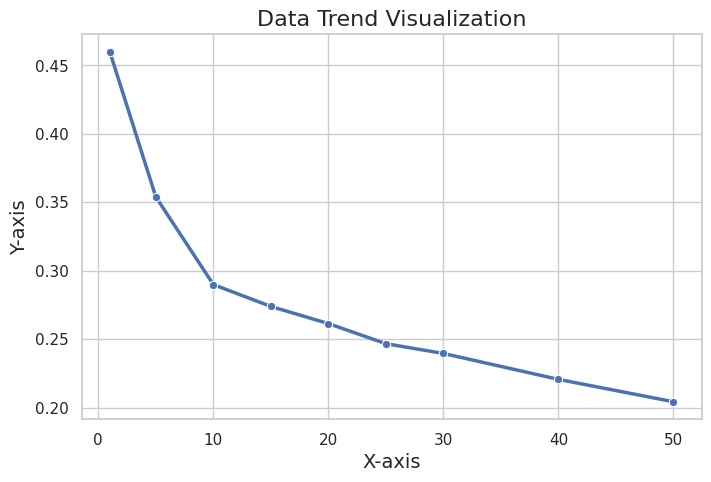

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
data = {1: 0.46,
        5: 0.35400000000000004,
        10: 0.2900000000000001,
        15: 0.27399999999999997,
        20: 0.2615,
        25: 0.24679999999999994,
        30: 0.2396666666666667,
        40: 0.22075,
        50: 0.20439999999999997}

# Preparing data for plotting
x = list(data.keys())
y = list(data.values())

# Set the style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=x, y=y, marker='o', linewidth=2.5, color='b')
sns.lineplot(x=x, y=y, marker='o', linewidth=2.5, color='b')


# Add titles and labels
plt.title("Data Trend Visualization", fontsize=16)
plt.xlabel("X-axis", fontsize=14)
plt.ylabel("Y-axis", fontsize=14)

# Show the plot
plt.show()

TypeError: 'function' object is not subscriptable

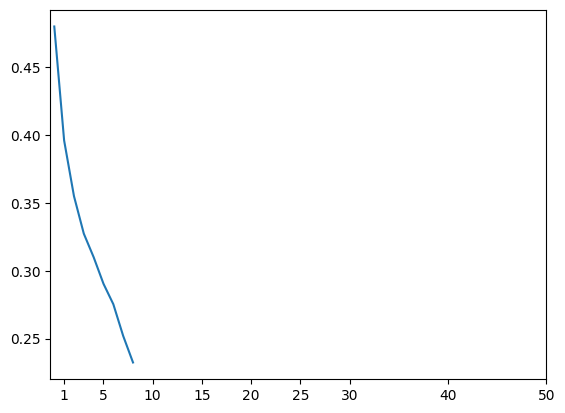

In [108]:
import pandas as pd
older_vals = pd.read_csv('./hybrid_precision_results.csv').values[0][1:]

/tmp/ipykernel_54790/2674889604.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


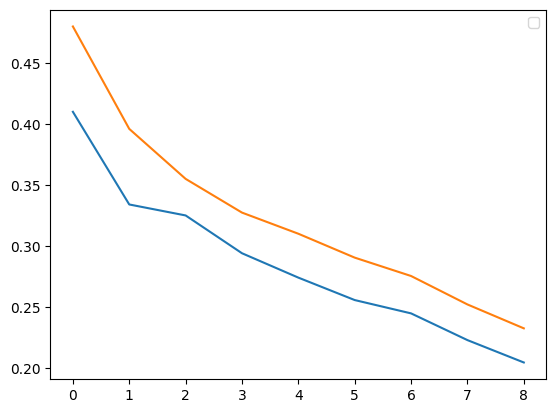

In [109]:
plt.plot(older_vals)
plt.plot(avg_prec.values())
plt.legend()

In [110]:
import pandas as pd
# d = {1: 0.41, # Old
#      5: 0.33399999999999985,
#      10: 0.32500000000000007,
#      15: 0.29399999999999976,
#      20: 0.27399999999999997,
#      25: 0.25559999999999994,
#      30: 0.24466666666666653,
#      40: 0.22275000000000006,
#      50: 0.20439999999999992}

# d = {1: 0.46, # New 1
#      5: 0.35400000000000004,
#      10: 0.2900000000000001,
#      15: 0.27399999999999997,
#      20: 0.2615,
#      25: 0.24679999999999994,
#      30: 0.2396666666666667,
#      40: 0.22075,
#      50: 0.20439999999999997}

d = avg_prec
df = pd.DataFrame(d, index=['Precision'])
df.to_csv('hybrid_precision_results_new.csv')